In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = sns.color_palette("Set2")[0]  # e.g. unweighted sample
COL_WEIGHTED = sns.color_palette("Set2")[1]  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [3]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/neuroaging/figures/fig3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [4]:
metrics = ["gm_vol"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})



# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_1790172/2153488554.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


In [5]:
metric_cols = {metric: "volume" if metric == "gm_vol" else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df


In [6]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [7]:
# assign weights
for metric in metrics:
    data[metric]["subject_code"] = data[metric]["subject_code"].astype(str).str.zfill(4)

In [8]:
df = data[metrics[0]].drop_duplicates(subset=["subject_code"],keep="first").copy()

In [9]:
import pandas as pd

def group_by_age(df, age_col:str = "age_at_scan",n_bins:int=50):
    """
    Group participants by age into n_bins with equal number of participants.
    
    Parameters:
    - df: DataFrame containing the data
    - age_col: Column name for age
    - n_bins: Number of bins to create
    
    Returns:
    - DataFrame with an additional column for age groups
    """
    # Create age groups with equal number of participants
    df["age_group"] = pd.qcut(df[age_col], q=n_bins, labels=False)

    # Optional: Assign labels like "Q1", "Q2", etc.
    df["age_group_label"] = pd.qcut(
        df[age_col], q=n_bins, labels=[f"Q{i+1}" for i in range(n_bins)]
    )
    # Group by the age_group_label column
    group_stats = df.groupby("age_group_label")["age_at_scan"].agg(
        median_age="median", mean_age="mean", sd_age="std", n_participants="count"
    )

    # Merge stats back into original df
    return df.merge(group_stats, on="age_group_label", how="left")
    



In [42]:
scns = {}
for metric in metrics:
    long_df = data[metric].copy()
    ages = group_by_age(long_df.drop_duplicates(subset="subject_code", keep="first"), age_col="age_at_scan", n_bins=50)
    age_group_map = ages[["subject_code", 'age_group_label']]
    if metric == "gm_vol":
        long_df["value"] = long_df["value"] / long_df["tiv"]
    wide_df = long_df.pivot_table(index="subject_code", columns=[region_col], values="value")
    # Step 2: Add age group info to wide matrix
    for group_name, group_df in ages.groupby("age_group_label"):
        # Create a new column for each age group
        region_matrix = wide_df.loc[group_df["subject_code"]]
        corr_matrix = region_matrix.corr(method="pearson")
        scns[group_name] = {"corr_matrix": corr_matrix, "metadata": group_df}
        # break
    # wide_df = wide_df.merge(age_group_map, left_on="subject_code", right_on="subject_code")
    # wide_df = wide_df.merge(age_group_map, left_on="subject_code", right_on="subject_code")
    # break

/tmp/ipykernel_1790172/2905021287.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_group"] = pd.qcut(df[age_col], q=n_bins, labels=False)
/tmp/ipykernel_1790172/2905021287.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_group_label"] = pd.qcut(
/tmp/ipykernel_1790172/2905021287.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

In [ ]:
import bct
from tqdm import tqdm
network_matrices_dict = {}

network_measures = {
    "degree": bct.degree_und,
    "strength": bct.strengths_und,
    "clustering": bct.clustering_coef_wu,
    "betweenness": bct.betweenness_wei,
    "global_efficiency": bct.efficiency_wei
    }

for group_name, group_data in tqdm(scns.items(), desc="Calculating network matrices"):
    mat = group_data["corr_matrix"].values.copy()
    metadata = group_data["metadata"].copy()
    np.fill_diagonal(mat, 0)  # Set diagonal to zero
    # Calculate the network matrices
    p = parcels.copy()
    for col, func in network_measures.items():
        p[col] = func(mat)
    p["group"] = group_name
    # Add metadata
    for col in ["median_age","mean_age", "sd_age", "n_participants"]:
        if col in metadata.columns:
            p[col] = metadata[col].values[0]
        else:
            p[col] = np.nan
    network_matrices_dict[group_name] = p
    # break

network_matrices = pd.concat(network_matrices_dict.values(), ignore_index=True)

Calculating network matrices: 100%|██████████| 50/50 [07:35<00:00,  9.10s/it]


In [68]:
X_full

,index,name,base_name,Label Name,network,component,hemisphere,global_efficiency,strength,clustering,group,median_age,mean_age,sd_age,n_participants
0,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000007,8.310254,0.019521,Q1,18.640,18.713778,0.410843,45
454,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000006,60.496391,0.064584,Q2,20.310,20.239773,0.385206,44
908,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000009,43.981944,0.041388,Q3,21.140,21.129091,0.185771,44
1362,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000007,49.193989,0.039577,Q4,21.650,21.645227,0.136663,44
1816,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000007,54.899478,0.044719,Q5,22.065,22.069545,0.127461,44
2270,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000007,50.574935,0.047538,Q6,22.530,22.504468,0.128212,47
2724,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000008,-3.206485,0.032569,Q7,22.800,22.806279,0.092891,43
3178,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000008,17.497690,0.015435,Q8,23.150,23.136190,0.079571,42
3632,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000007,68.044763,0.074745,Q9,23.470,23.437955,0.089041,44
4086,1,7Networks_LH_Vis_1,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,-0.000008,64.736198,0.066272,Q10,23.780,23.752128,0.074831,47


In [82]:
# do ols
import statsmodels.api as sm

stats = {key: parcels.copy() for key in ["strength", "degree", "betweenness", "clustering"]}
for key, s in stats.items():
    # correlate between each metric and age
    for i, row in parcels.iterrows():
        # Prepare the data for OLS regression
        X_full = network_matrices.loc[network_matrices[region_col] == row[region_col]]
        X = sm.add_constant(X_full[key])
        y = X_full["median_age"].astype(float)
        # Fit the OLS model
        lin_model = sm.OLS(y, X).fit()
        quad_model = sm.OLS(y, sm.add_constant(np.column_stack((X_full[key], X_full[key] ** 2)))).fit()
        # Store the results
        s.loc[i, "slope"] = lin_model.params[1]
        s.loc[i, "intercept"] = lin_model.params[0]
        s.loc[i, "pval"] = lin_model.f_pvalue
        s.loc[i, "adj_r2"] = lin_model.rsquared_adj
        s.loc[i, "quad_slope"] = quad_model.params[1]
        s.loc[i, "quad_intercept"] = quad_model.params[0]
        s.loc[i, "quad_pval"] = quad_model.f_pvalue
        s.loc[i, "quad_adj_r2"] = quad_model.rsquared_adj
        # compare the models
        f, p, _ = quad_model.compare_f_test(lin_model)
        s.loc[i, "f_statistic"] = f
        s.loc[i, "pval_quad_vs_linear"] = p
        # break
    break

/tmp/ipykernel_1790172/3491378822.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.loc[i, "slope"] = lin_model.params[1]
/tmp/ipykernel_1790172/3491378822.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.loc[i, "intercept"] = lin_model.params[0]
/tmp/ipykernel_1790172/3491378822.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.loc[i, "quad_slope"] = quad_model.params[1]
/tmp/ipykernel_1790172/3491378822.py:21: Futu

In [84]:
s.sort_values("quad_pval")

,index,name,base_name,Label Name,network,component,hemisphere,slope,intercept,pval,adj_r2,quad_slope,quad_intercept,quad_pval,quad_adj_r2,f_statistic,pval_quad_vs_linear
333,334,7Networks_RH_Cont_Par_3,7networks_rh_cont_par,7Networks_RH_Cont_Par,control,parietal,R,0.231672,20.666391,0.000609,0.202789,-0.702830,38.871078,1.142056e-07,0.471943,25.465953,7.189937e-06
448,449,mAMY-lh,mAMY,"Amygdala, medial nucleus",subcortex,Amygdala,L,0.242408,16.011187,0.000015,0.312606,-0.308312,30.557549,1.189439e-07,0.471029,15.375684,2.852431e-04
166,167,7Networks_LH_Default_PFC_2,7networks_lh_default_pfc,7Networks_LH_Default_PFC,default,prefrontal cortex,L,0.078748,27.090650,0.242169,0.008143,-1.021853,51.946126,1.263671e-07,0.469664,42.771686,4.081610e-08
27,28,7Networks_LH_Vis_28,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.134865,25.634052,0.022498,0.085138,-0.340900,30.872983,2.808206e-07,0.451334,33.036621,6.470049e-07
2,3,7Networks_LH_Vis_3,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,0.224332,25.369884,0.000045,0.281162,-0.097847,26.021746,4.226935e-07,0.441703,14.802633,3.587837e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,262,7Networks_RH_SomMot_32,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,0.000115,31.418312,0.998876,-0.020833,-0.081530,33.108503,9.635048e-01,-0.040905,0.074413,7.862123e-01
165,166,7Networks_LH_Default_PFC_1,7networks_lh_default_pfc,7Networks_LH_Default_PFC,default,prefrontal cortex,L,-0.010475,31.923944,0.871313,-0.020270,0.028311,31.177331,9.690537e-01,-0.041160,0.036922,8.484525e-01
64,65,7Networks_LH_SomMot_34,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,0.006907,31.102312,0.919805,-0.020616,0.071641,29.797993,9.768563e-01,-0.041515,0.036817,8.486650e-01
357,358,7Networks_RH_Cont_Cing_1,7networks_rh_cont_cing,7Networks_RH_Cont_Cing,control,cingulate,R,0.006532,31.171688,0.933239,-0.020683,-0.017570,31.551338,9.913103e-01,-0.042166,0.010513,9.187690e-01


<Axes: xlabel='median_age', ylabel='global_efficiency'>

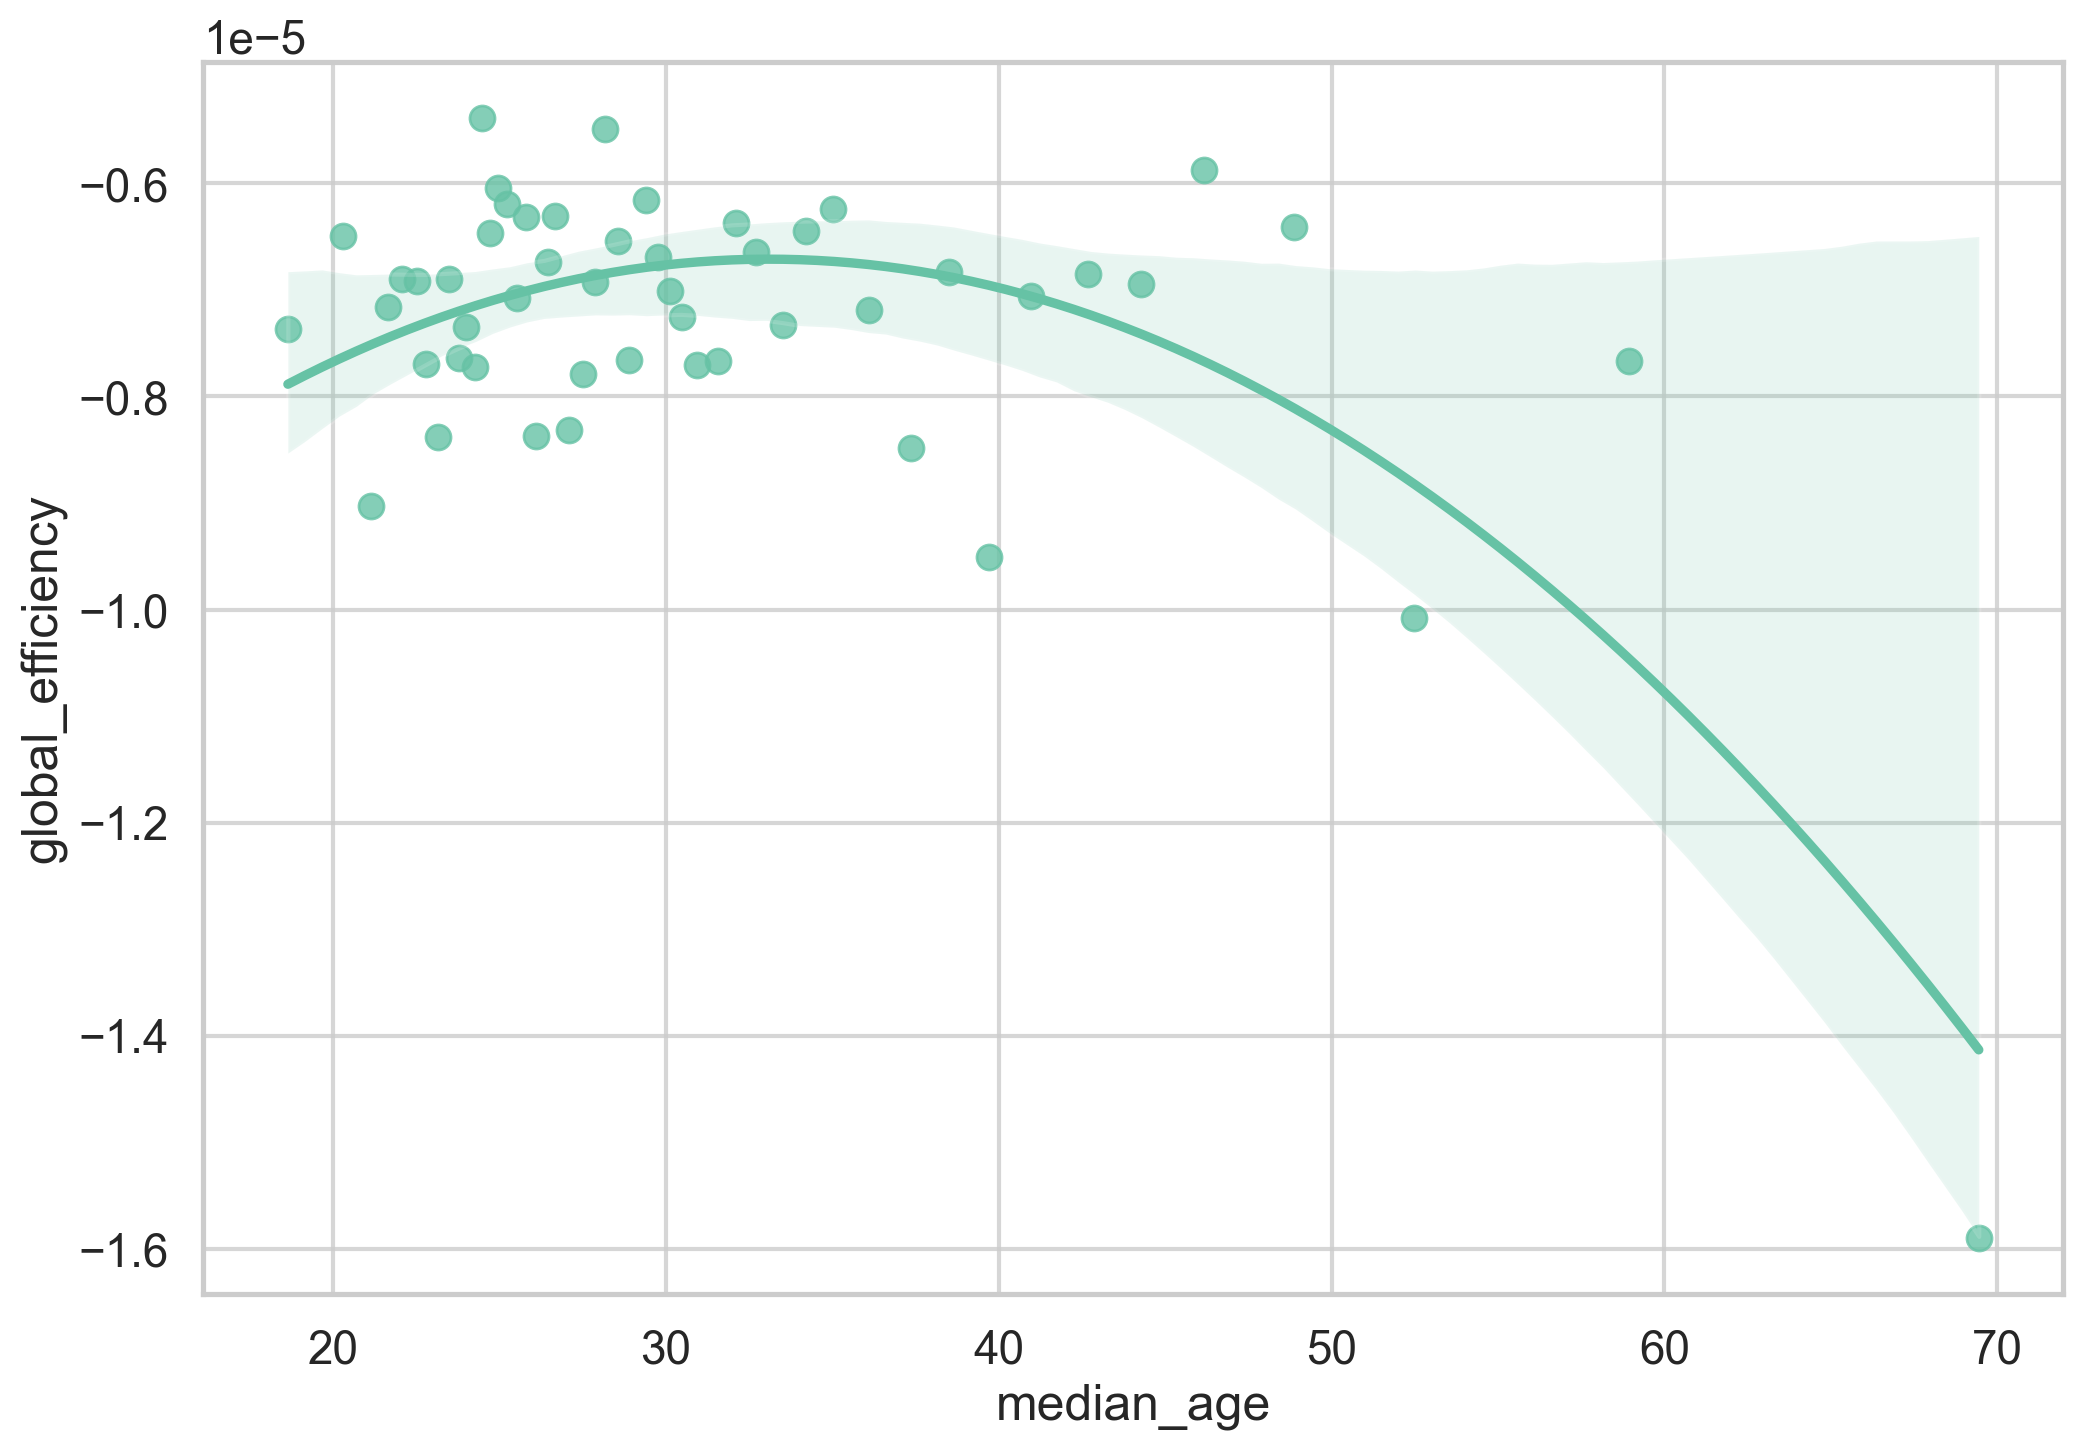

In [59]:
sns.regplot(
    data=network_matrices.drop_duplicates(subset=["group"], keep="first"),
    y="global_efficiency",
    x="median_age",
    order=2
)

<Axes: xlabel='age_group_label', ylabel='age_at_scan'>

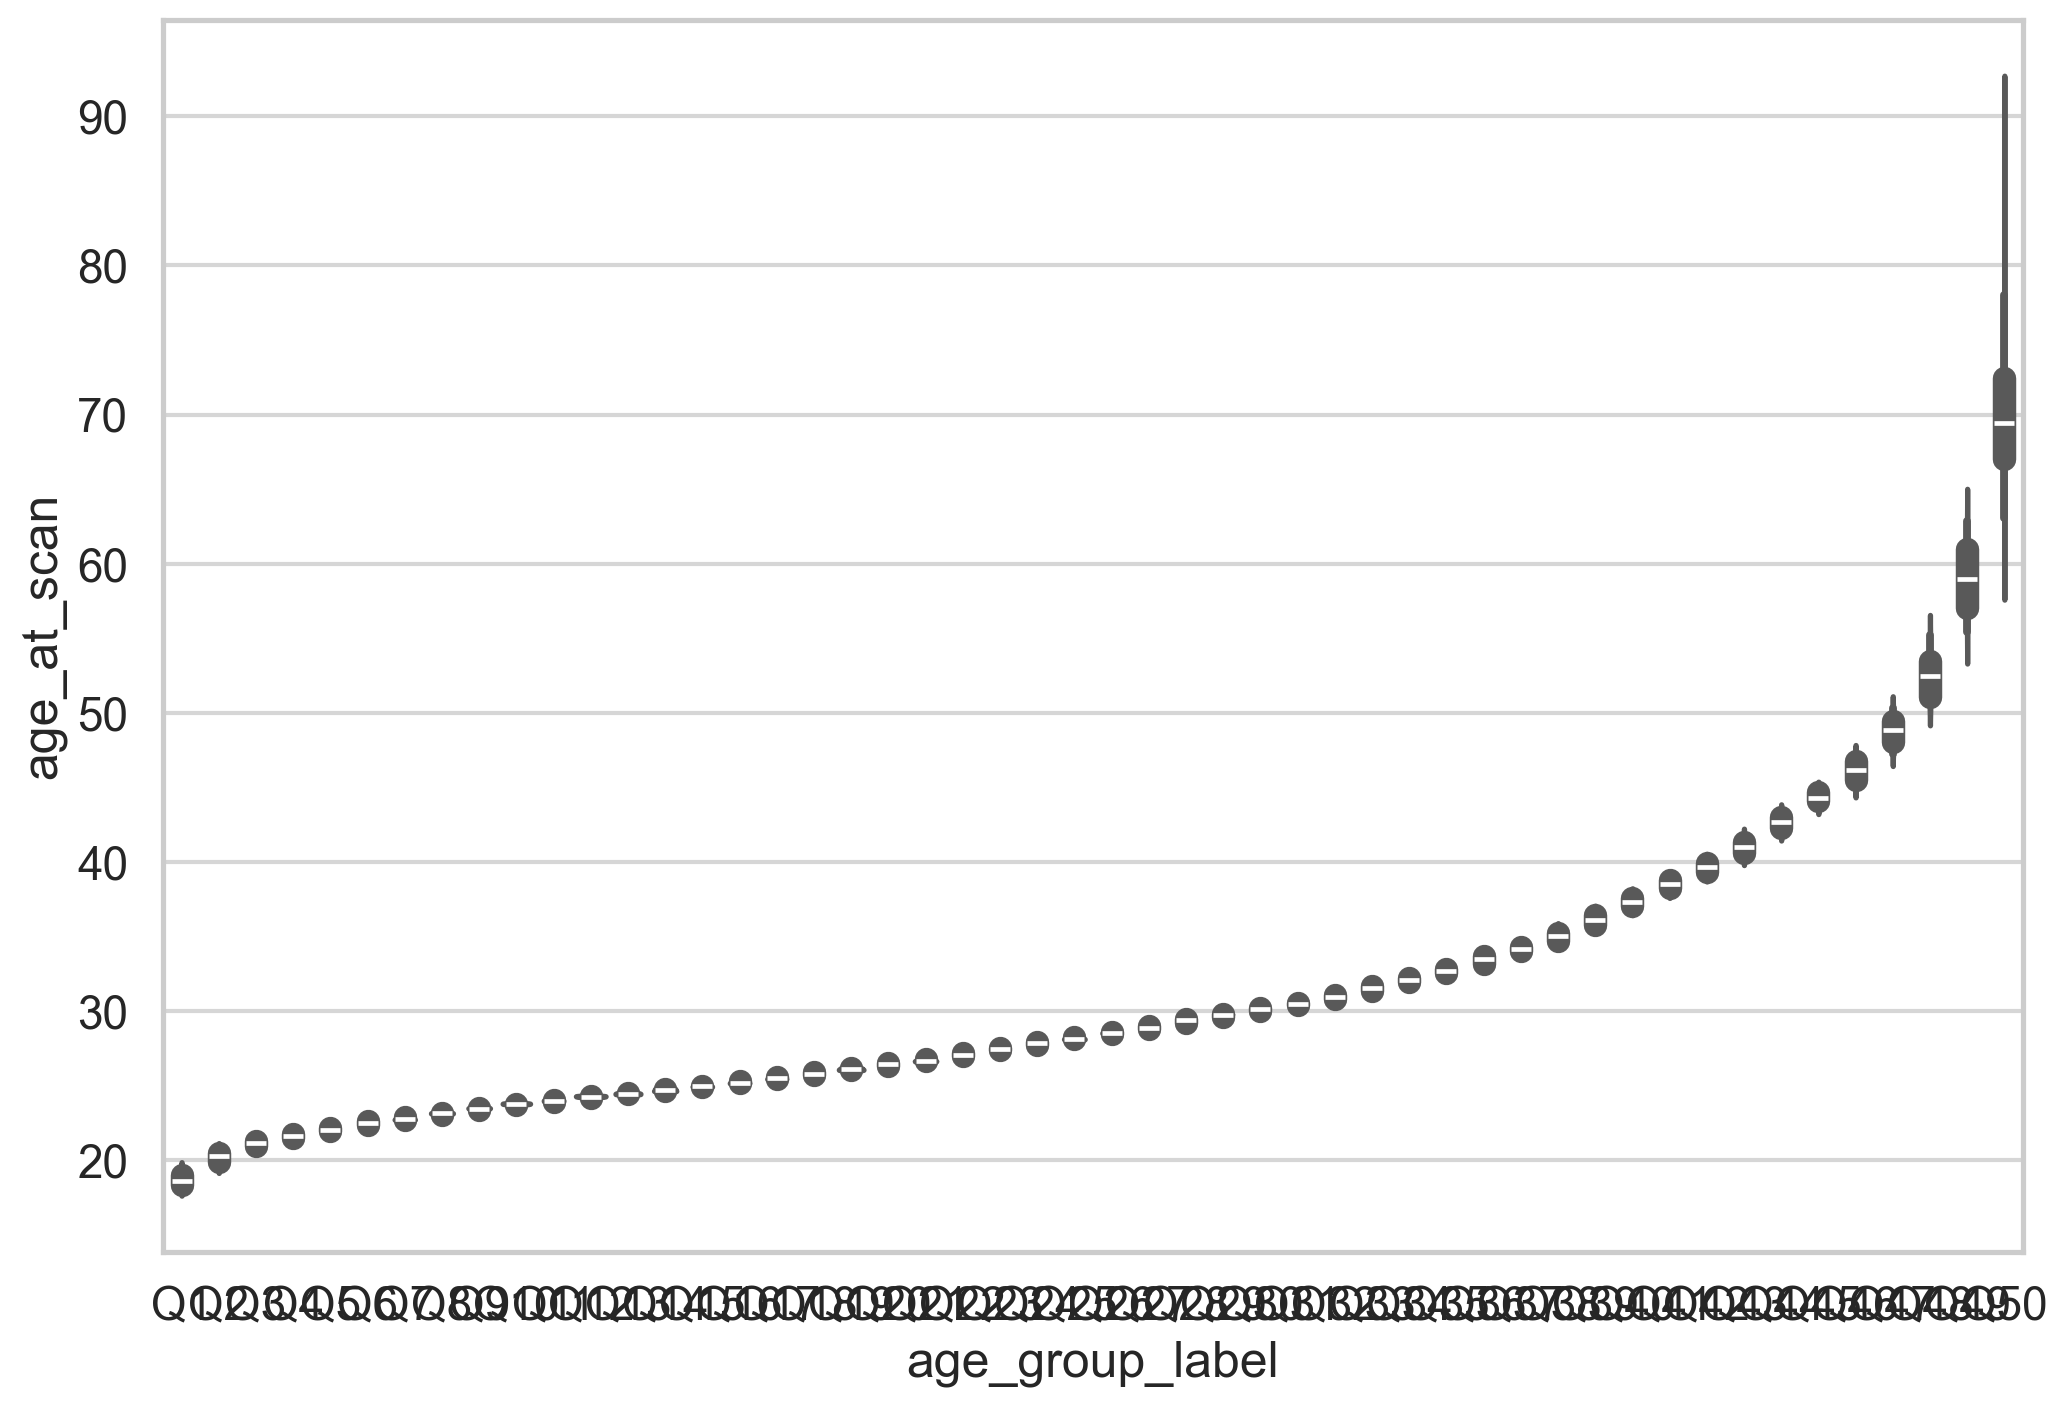

In [41]:
import seaborn as sns

sns.violinplot(
    data=df,
    x="age_group_label",
    y="age_at_scan"
)